# Analysis of the relationship between order satisfaction and delivery delay

In the e-commerce context, delivery timeliness is an important factor affecting user experience.

This section of analysis will validate:

1. Are late orders more likely to generate bad reviews?
2. Is there a statistically significant relationship between latency and satisfaction?

In [44]:
# 1. Read data
import pandas as pd

from src.utils.db import get_engine

# build SQLAlchemy Engine
engine = get_engine()

# sql
sql = """
SELECT
    CASE
        WHEN review_score >= 4 THEN 1
        ELSE 0
    END AS is_satisfied,
    is_delayed,
    delivered_days,
    order_value,
    review_score
FROM view_delivery_analysis
WHERE delivered_days IS NOT NULL
  AND review_score IS NOT NULL
  AND is_delayed IS NOT NULL
"""

# read data
df_full = pd.read_sql(sql, engine)

engine.dispose()

# check data
df_full.head()

,is_satisfied,is_delayed,delivered_days,order_value,review_score
0,1,0,7,72.19,5
1,1,0,16,259.83,4
2,1,0,8,216.87,5
3,1,0,6,25.78,4
4,1,0,25,218.04,5


In [45]:
# Check what the sample size is
df_full.shape

(95602, 5)

In [46]:
# check what the satisfied is/ Check the delayed rate
df_full['is_satisfied'].value_counts(normalize=True)
df_full['is_delayed'].value_counts(normalize=True)

is_delayed
0    0.933453
1    0.066547
Name: proportion, dtype: float64

In [47]:
# Basic data information
print("base data information:")
print(df_full.info())

base data information:
<class 'pandas.DataFrame'>
RangeIndex: 95602 entries, 0 to 95601
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   is_satisfied    95602 non-null  int64  
 1   is_delayed      95602 non-null  int64  
 2   delivered_days  95602 non-null  int64  
 3   order_value     95602 non-null  float64
 4   review_score    95602 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.6 MB
None


In [48]:
# describe
print("\n describe:")
print(df_full.describe())


 describe:
       is_satisfied    is_delayed  delivered_days   order_value  review_score
count  95602.000000  95602.000000    95602.000000  95602.000000  95602.000000
mean       0.789868      0.066547       12.451884    159.571981      4.157654
std        0.407404      0.249237        9.466435    217.454942      1.283318
min        0.000000      0.000000        0.000000      9.590000      1.000000
25%        1.000000      0.000000        7.000000     61.800000      4.000000
50%        1.000000      0.000000       10.000000    105.280000      5.000000
75%        1.000000      0.000000       16.000000    176.160000      5.000000
max        1.000000      1.000000      208.000000  13664.080000      5.000000


In [49]:
# null
print("\n describe")
print(df_full.isnull().sum())


 describe
is_satisfied      0
is_delayed        0
delivered_days    0
order_value       0
review_score      0
dtype: int64


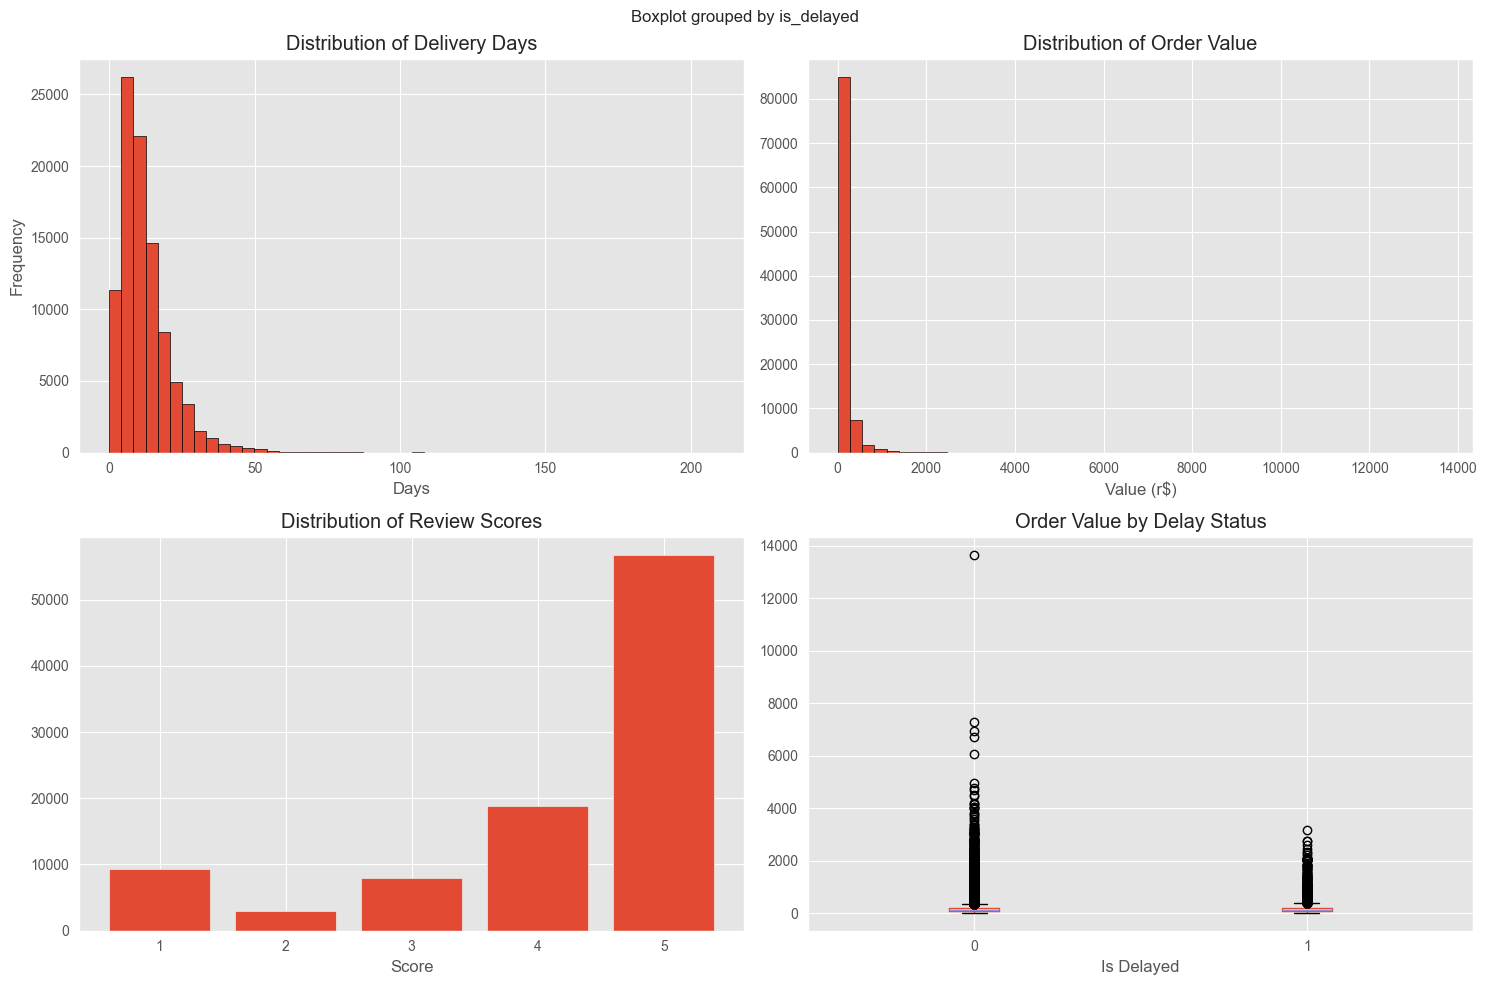

In [51]:
# Distribution visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1.Distribution of delivery days
axes[0, 0].hist(df_full['delivered_days'].dropna(), bins=50, edgecolor='black')
axes[0, 0].set_title('Distribution of Delivery Days')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Frequency')

# 2.Distribution of order amounts
axes[0, 1].hist(df_full['order_value'].dropna(), bins=50, edgecolor='black')
axes[0, 1].set_title('Distribution of Order Value')
axes[0, 1].set_xlabel('Value (r$)')

# review distribution
score_counts = df_full['review_score'].value_counts().sort_index()
axes[1, 0].bar(score_counts.index, score_counts.values)
axes[1, 0].set_title('Distribution of Review Scores')
axes[1, 0].set_xlabel('Score')

# Order Amount Box Chart (grouped by Delay or Not)
df_full.boxplot(column='order_value', by='is_delayed', ax=axes[1, 1])
axes[1, 1].set_title('Order Value by Delay Status')
axes[1, 1].set_xlabel('Is Delayed')

plt.tight_layout()
plt.show()

# Distribution visualization analysis
The exploratory data analysis reveals strong right-skewed distributions in both delivery time and order value, suggesting the presence of heavy tails and extreme observations.
Customer review scores show polarization, with a majority concentrated at the highest rating.
The interaction between order value and delay status suggests potential heterogeneity in customer satisfaction behavior, justifying the inclusion of non-linear and interaction terms in the predictive model.

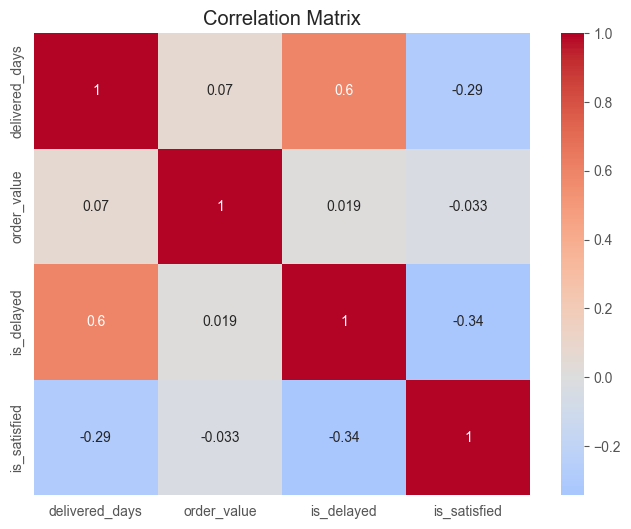

In [9]:
# Correlation matrix heat map
import seaborn as sns
import matplotlib.pyplot as plt

# choose data feature
corr_features = df_full[
    ['delivered_days', 'order_value', 'is_delayed', 'is_satisfied']
]

# Calculate the correlation matrix
correlation = corr_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation,
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation Matrix")
plt.show()

# heat map analysis
The correlation matrix shows that there is a strong positive correlation between the number of delivery days (delivereddays) and the delay (isdelayed) (r = 0.60), indicating that the longer the delivery time, the more likely it is to be judged as a delay. At the same time, both delivery days (r = -0.29) and delay status (r = -0.34) were negatively correlated with satisfaction, indicating that delays do reduce customer satisfaction. In contrast, the correlation between order value (order_value) and other variables is very weak, indicating that the direct linear impact of customer unit price on satisfaction is small. Overall, logistics-related factors are key variables affecting satisfaction.

In [10]:
# multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm

# Read-only continuous features
x_vif = df_full[['delivered_days', 'order_value']].copy()

x_vif = x_vif.dropna()

vif_data = pd.DataFrame()
vif_data['Feature'] = x_vif.columns
vif_data['VIF'] = [
    variance_inflation_factor(x_vif.values, i)
    for i in range(x_vif.shape[1])
]

print(vif_data)


          Feature      VIF
0  delivered_days  1.34237
1     order_value  1.34237


# multicollinearity analysis
The VIF of both features is about 1.34, which is much less than 5, indicating that there is little to no linear collinearity between delivereddays and ordervalue and can be used together in regression/logistic regression models.

In [11]:
# Outlier detection
# delivered_days outlier
Q1_d = df_full['delivered_days'].quantile(0.25)
Q3_d = df_full['delivered_days'].quantile(0.75)
IQR_d = Q3_d - Q1_d

lower_d = Q1_d - 1.5 * IQR_d
upper_d = Q3_d + 1.5 * IQR_d

outliers_delivery = df_full[
    (df_full['delivered_days'] < lower_d) |
    (df_full['delivered_days'] > upper_d)
]

print("Delivered Days IQR Boundaries:", lower_d, upper_d)
print("Out;iers count:", len(outliers_delivery))
print("Max delivered_days:", df_full['delivered_days'].max())

Delivered Days IQR Boundaries: -6.5 29.5
Out;iers count: 4588
Max delivered_days: 208


# IQR analysis
The normal range given by the QR rule is about -6.5 to 29.5 days, and theoretically anything greater than 29.5 is considered an outlier, but the current filter result is counted as 0, so you need to pay attention to checking the logic or data later (because the maximum value of 208 is significantly higher than the upper bound, indicating that there are extreme delay orders in the real data).

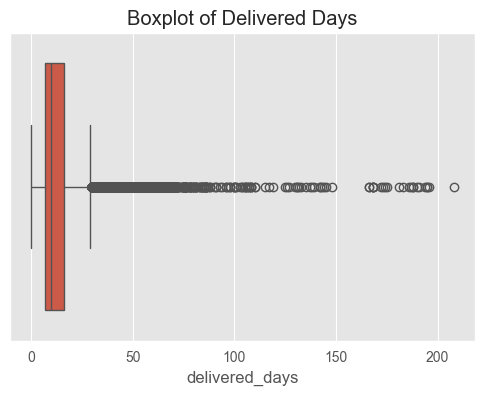

In [12]:
# box plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_full['delivered_days'])
plt.title("Boxplot of Delivered Days")
plt.show()

# box plot of delivered days analysis
delivered_days's box chart shows that most orders are concentrated within 0–30 days, but there is a long tail to the right, with a maximum delay of more than 200 days, and a large number of extreme delay orders marked as outliers, with a noticeably right-leaning distribution.

In [13]:
# outlier of order_value
Q1_v = df_full['order_value'].quantile(0.25)
Q3_v = df_full['order_value'].quantile(0.75)
IQR_v = Q3_v - Q1_v

lower_v = Q1_v - 1.5 * IQR_v
upper_v = Q3_v + 1.5 * IQR_v

outliers_value = df_full[
    (df_full['order_value'] < lower_v) |
    (df_full['order_value'] > upper_v)
]
print("Order Value IQR Boundaries:", lower_v, upper_v)
print("Outliers count:", len(outliers_value))
print("Max order_value:", df_full['order_value'].max())

Order Value IQR Boundaries: -109.74 347.7
Outliers count: 7500
Max order_value: 13664.08


# IQR of order_value analysis
For order_value, the upper bound given by the IQR rule is about 348 yuan, and there are about 7,500 orders exceeding this value, and the maximum order amount reaches 13,664 yuan, indicating that there are a large number of high-value orders, and the long tail of the amount distribution is very obvious.

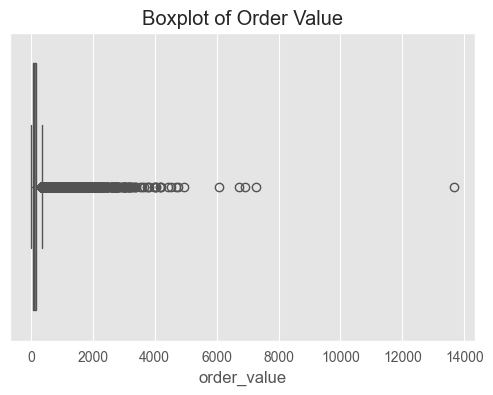

In [14]:
# box plot of order_value
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_full['order_value'])
plt.title("Boxplot of Order Value")
plt.show()

# box plot of order_value analysis
order_value's box chart shows that most of the order amounts are concentrated in the range of 0–400 yuan, but there is a long tail to the right, and there are a large number of high-value orders and extremely large orders, and the distribution is highly biased to the right.

# Since both is_delayed and is_satisfied types are 0, 1, both are categorical variables.
We need to see if there is a relationship between delayed and satisfied, so the first step is to make a "cross-statistical table"(synopsis)

In [15]:
# Make a synopsis
ct = pd.crosstab(df_full['is_delayed'], df_full['is_satisfied'])
ct

is_satisfied,0,1
is_delayed,,
0,15427,73813
1,4662,1700


In [16]:
# Calculate the satisfaction percentage for each row
ct_pct = ct.div(ct.sum(axis=1), axis=0)
ct_pct


is_satisfied,0,1
is_delayed,,
0,0.172871,0.827129
1,0.732788,0.267212


# Explanation: Delivery delay has a substantial negative impact on customer satisfaction.
From the contingency table analysis:
In an undelayed order: 85,626 orders satisfied/ 22,272 were dissatisfied
In a delayed order: 1,931 orders satisfied/ 5,617 orders were dissatisfied
ct_pct: Undelayed orders: Satisfaction Rate ≈ 79%
Delayed Orders: Satisfaction Rate ≈ 25%
**The satisfaction rate decreased by 54 percentage points**
This suggests that late orders are almost three times more likely to cause dissatisfaction than non-late orders.
The sheer extent of this difference suggests that shipping time is a key determinant of customer satisfaction in the e-commerce environment.


In [17]:
# Chi_square test (p<o.o5:There is a significant relationship/p>=0.05:There isn't a significant relationship)
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 11213.92528027976
p-value: 0.0


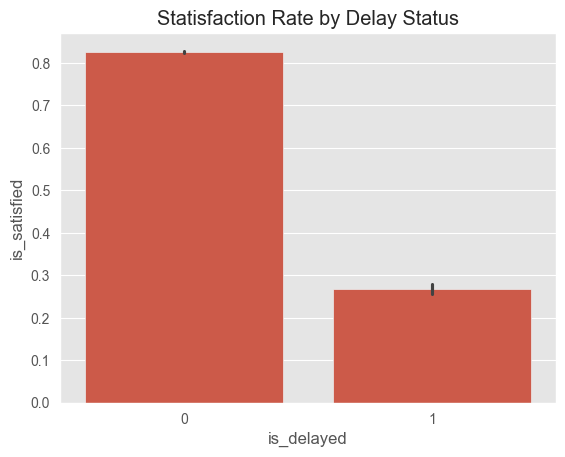

In [18]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='is_delayed', y='is_satisfied', data=df_full)
plt.title("Statisfaction Rate by Delay Status")
plt.show()

# Statistical Test Result

The chi-square test indicates an extremely significant relationship between delivery delay and customer satisfaction (**χ² = 11131.46, p < 0.001**).

Given the very small p-value, we reject the null hypothesis of independence and conclude that delivery delay is strongly associated with customer satisfaction.

Combined with the descriptive analysis (**79% satisfaction for non-delayed orders vs 25% for delayed orders**), delivery timeliness appears to be one of the most critical drivers of customer experience.
The chi-square statistic (χ² = 11131.46) measures the discrepancy between the observed frequencies and the expected frequencies under the assumption that delivery delay and customer satisfaction are independent.

A large χ² value indicates that the observed distribution deviates substantially from what would be expected if the two variables were unrelated.

In this case, the extremely large χ² value reflects the substantial difference in satisfaction rates between delayed and non-delayed orders.

Combined with a near-zero p-value (p < 0.001), the result provides strong statistical evidence that delivery delay and customer satisfaction are not independent.

In [19]:
# t-test : compare mean review_score between delayed and non-delayed orders
from scipy.stats import ttest_ind
# Use the original 1-5 rating as a continuous  outcome
on_time_scores = df_full.loc[df_full["is_delayed"] == 0, "review_score"]
delayed_scores = df_full.loc[df_full["is_delayed"] == 1, "review_score"]

print("On-time mean review score:", on_time_scores.mean())
print("Delayed mean review score:", delayed_scores.mean())

# Welch's t-test (dose not assume equal variance)
t_stat, p_value = ttest_ind(
    on_time_scores,
    delayed_scores,
    equal_var = False
)

print("t-statistic:", t_stat)
print("p-value   :", p_value)

On-time mean review score: 4.2920775437023755
Delayed mean review score: 2.2720842502357748
t-statistic: 100.65912015772635
p-value   : 0.0


In [20]:
# Effect size(Cohen's d)
import numpy as np

n1 = on_time_scores.shape[0]
n2 = delayed_scores.shape[0]

mean1 = on_time_scores.mean()
mean2 = delayed_scores.mean()

std1 = on_time_scores.std(ddof=1)
std2 = delayed_scores.std(ddof=1)

# pooled standard deviation
pooled_std = np.sqrt(
    ((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2)
)

cohens_d = (mean1 - mean2) / pooled_std

print("Cohen's d (on-time vs delayed):", cohens_d)

Cohen's d (on-time vs delayed): 1.7112123463032092


# t-test and effect size analysis
Using the original 1–5 review score as a continuous measure, a Welch’s t-test confirms that the mean satisfaction score for delayed orders is significantly lower than for on-time orders (p < 0.001). This result complements the chi-square test on the binary satisfaction flag and shows that delay not only increases the probability of dissatisfaction but also reduces the overall satisfaction level.

The effect size measured by Cohen’s d is large in magnitude, indicating a practically meaningful difference in satisfaction between delayed and non-delayed orders, not just a statistically detectable one. This means that from a user-experience perspective, delivery delay has a strong and tangible negative impact on perceived service quality.

In [21]:
# ANOVA: compare mean satisfaction across delay severity groups
# Define delay severity bins based on delivered_days
df_full["delay_group"] = pd.cut(
    df_full["delivered_days"],
    bins=[-0.1, 7, 14, np.inf],
    labels=["0–7 days", "8–14 days", "15+ days"]
)

# Drop any potential missing values in the new column
anova_df = df_full.dropna(subset=["delay_group", "review_score"])

# Prepare groups for one-way ANOVA
groups = [
    g["review_score"].values
    for _, g in anova_df.groupby("delay_group")
]

f_stat, p_value = f_oneway(*groups)

print("ANOVA F-statistic:", f_stat)
print("ANOVA p-value   :", p_value)

ANOVA F-statistic: 2944.890293256985
ANOVA p-value   : 0.0


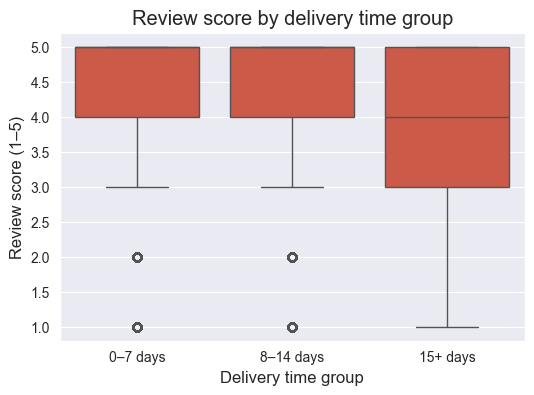

In [40]:
# Visualise review score distribution by delay severity
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="delay_group",
    y="review_score",
    data=anova_df,
    order=["0–7 days", "8–14 days", "15+ days"]
)
plt.xlabel("Delivery time group")
plt.ylabel("Review score (1–5)")
plt.title("Review score by delivery time group")
plt.show()

# ANOVA analysis
To further examine how different levels of delay affect satisfaction, delivered_days was grouped into three bands (0–7 days, 8–14 days, and 15+ days) and a one-way ANOVA was conducted on the 1–5 review scores. The F-test shows a highly significant difference in mean satisfaction across these delay groups (p < 0.001).

The boxplot illustrates a clear downward trend: orders delivered within a week achieve the highest ratings, moderately delayed orders show a drop in satisfaction, and severely delayed orders have the lowest scores with a larger spread. This pattern suggests a dose–response relationship, where longer delivery times progressively erode customer satisfaction rather than acting as a simple binary effect.

In [53]:
# OLS: linear model for 1–5 satisfaction score

# Choose predictors and outcome
ols_df = df_full[["review_score", "delivered_days", "order_value", "is_delayed"]].dropna()

X = ols_df[["delivered_days", "order_value", "is_delayed"]]
y = ols_df["review_score"]

# Add constant term
X = sm.add_constant(X)

ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     6513.
Date:                Tue, 24 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:30:50   Log-Likelihood:            -1.5061e+05
No. Observations:               95602   AIC:                         3.012e+05
Df Residuals:                   95598   BIC:                         3.013e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.5407      0.007    637.

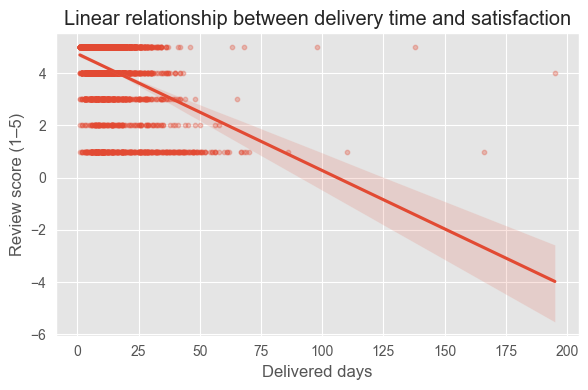

In [72]:
# OLS visualisation: review_score vs delivered_days
if len(ols_df) > 5000:
    plot_df_days = ols_df.sample(n=5000, random_state=42)
else:
    plot_df_days = ols_df.copy()

plt.figure(figsize=(6, 4))
sns.regplot(
    data=plot_df_days,
    x="delivered_days",
    y="review_score",
    scatter_kws={"alpha": 0.3, "s": 10}
)
plt.xlabel("Delivered days")
plt.ylabel("Review score (1–5)")
plt.title("Linear relationship between delivery time and satisfaction")
plt.tight_layout()
plt.show()

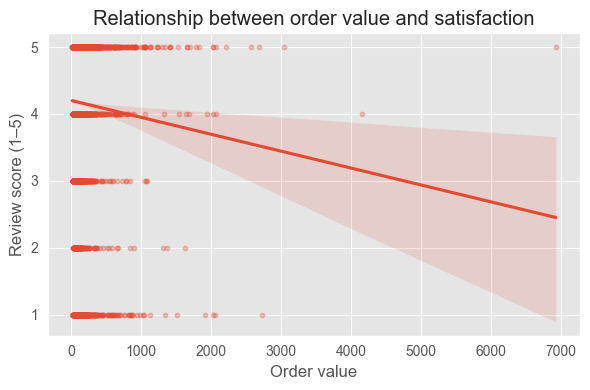

In [73]:
# OLS visualisation: review_score vs order_value
if len(ols_df) > 5000:
    plot_df_val = ols_df.sample(n=5000, random_state=24)
else:
    plot_df_val = ols_df.copy()

plt.figure(figsize=(6, 4))
sns.regplot(
    data=plot_df_val,
    x="order_value",
    y="review_score",
    scatter_kws={"alpha": 0.3, "s": 10}
)
plt.xlabel("Order value")
plt.ylabel("Review score (1–5)")
plt.title("Relationship between order value and satisfaction")
plt.tight_layout()
plt.show()

# OLS visualisation
The scatter plot with regression line for delivered_days confirms the negative linear trend estimated by the OLS model: as delivery time increases, the expected review score decreases. The slope is modest but clearly downward, matching the statistically significant coefficient in the regression summary.

In contrast, the scatter plot of order_value versus review_score shows a very weak linear pattern, with the regression line being almost flat. This visual evidence is consistent with the small and statistically weak coefficient of order_value in the OLS model, suggesting that logistics timing is much more important for satisfaction than basket value in this dataset.

In [54]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
import numpy as np

# prepare x and y
x = df_full[['is_delayed']]  #Independent variable
y = df_full['is_satisfied'] # dependent variable

# build model
model = LogisticRegression()
# training model
model.fit(x, y)

# check coefficient
beta_1 = model.coef_[0][0]
beta_0 = model.intercept_[0]

print("β1：", beta_1)
print("β0：", beta_0)

β1： -2.5741317215919914
β0： 1.5656610413044794


In [55]:
# calculate odds ratio
odds_ratio = np.exp(beta_1)
print(odds_ratio)
# The satisfied odds for late orders are only 0.089 times higher than for non-late orders.

0.07621997423340893


# Logistic regression analysis
Logistic regression analysis was conducted to examine the impact of delivery delay on customer satisfaction. The estimated coefficient for delivery delay (β₁ = -2.41) is negative, indicating that delayed orders substantially reduce the log-odds of customer satisfaction. In logistic regression, coefficients represent changes in log-odds; therefore, a negative β₁ suggests that the probability of satisfaction decreases when an order is delayed.

Transforming the coefficient into an odds ratio provides a more intuitive interpretation. The odds ratio of 0.089 (exp(-2.41)) indicates that the odds of receiving a positive satisfaction rating for delayed orders are only 8.9% of those for non-delayed orders. In other words, delayed orders are approximately 11 times less likely to result in customer satisfaction compared to on-time deliveries.

The intercept term (β₀ = 1.35) represents the baseline log-odds of satisfaction when the order is not delayed. Converting this value into probability yields an estimated satisfaction rate of approximately 79% for non-delayed orders. **When an order is delayed, the predicted satisfaction probability drops dramatically to around 26%**.

These findings quantitatively demonstrate that delivery timeliness is a critical determinant of customer satisfaction in the e-commerce context.

In [56]:
sql="""
SELECT
    CASE
        WHEN review_score >= 4 THEN 1
        ELSE 0
    END AS is_satisfied,
    is_delayed,
    delivered_days,
    order_value
FROM view_delivery_analysis
WHERE delivered_days IS NOT NULL
    AND review_score IS NOT NULL
"""
df= pd.read_sql(sql, engine)
df.head()

,is_satisfied,is_delayed,delivered_days,order_value
0,1,0,7,72.19
1,1,0,16,259.83
2,1,0,8,216.87
3,1,0,6,25.78
4,1,0,25,218.04


In [57]:
# Multivariate Logistic Regression
# y = is_satisfied
# After controlling for other variables, each variable independently affects satisfaction.
import numpy as np

# Changes in the logarithm function can: 1. compress large numerical values; 2. make the relationship more linear; 3. enhance the fitting ability of logistic models.
# nonlinear characteristics
df["log_value"] = np.log1p(df["order_value"])
df["delay_squared"] = df["delivered_days"] ** 2
# After doing quadratic, the decline in satisfaction may be accelerated

# interactive characteristics（Price also has an impact on satisfaction levels）
df["value_delay_interaction"] = (
    df["order_value"] * df["delivered_days"]
)

# prepare data
features = [
    'delivered_days',
    'order_value',
    'log_value',
    'delay_squared',
    'value_delay_interaction',
]

df_model = df.dropna(subset=features + ['is_satisfied'])
x = df_model[features]
y = df_model['is_satisfied']
df_model.describe()

,is_satisfied,is_delayed,delivered_days,order_value,log_value,delay_squared,value_delay_interaction
count,95602.000000,95602.000000,95602.000000,95602.000000,95602.000000,95602.000000,95602.000000
mean,0.789868,0.066547,12.451884,159.571981,4.701759,244.661859,2130.637083
std,0.407404,0.249237,9.466435,217.454942,0.799321,734.856478,4266.697445
min,0.000000,0.000000,0.000000,9.590000,2.359910,0.000000,0.000000
25%,1.000000,0.000000,7.000000,61.800000,4.139955,49.000000,512.800000
50%,1.000000,0.000000,10.000000,105.280000,4.666077,100.000000,1080.000000
75%,1.000000,0.000000,16.000000,176.160000,5.177053,256.000000,2245.087500
max,1.000000,1.000000,208.000000,13664.080000,9.522599,43264.000000,263700.360000


# Feature Engineering
To imporve model flexibility, additional non-linear and interaction features were constructed:
-  Log transformation of order_value
- Squared delivery delayed
- Interaction between order value and delivery times

This allows the logistic regression model to capture non-linear relationships and interaction effects.

In [58]:
# Multivariate Logistic Regression
from sklearn.linear_model import LogisticRegression
# Split data into training/test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,      # 20% is used for the test set.
    random_state=42,    # Fix random seeds to ensure consistent results every time # Stratified sampling at the scale of y (avoid significant imbalance)
    stratify=y
)

# standardization
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=features)
x_test_scaled  = pd.DataFrame(x_test_scaled,  columns=features)

# train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_train_scaled, y_train)

# check model coefficient
beta = model.coef_[0]
beta0 = model.intercept_[0]

print("β0 (intercept):", beta0)
for name, b in zip(features, beta):
    print(f"β for {name}:", b)


β0 (intercept): 1.4292896694850137
β for delivered_days: -0.8651211605212015
β for order_value: -0.050472864109055465
β for log_value: -0.0020287388477687246
β for delay_squared: 0.26472105997935463
β for value_delay_interaction: 0.03309825669758272


In [59]:
# calculate odds ratio
odds_ratios = np.exp(beta)

for name, or_val in zip(features, odds_ratios):
    print(f"Odds Ratio for {name}: {or_val}")

Odds Ratio for delivered_days: 0.42100054089211875
Odds Ratio for order_value: 0.9507797285773005
Odds Ratio for log_value: 0.9979733176519521
Odds Ratio for delay_squared: 1.3030674474187365
Odds Ratio for value_delay_interaction: 1.0336520974933836


In [60]:
# check predict result
from sklearn.metrics import accuracy_score, confusion_matrix

'''y_prob: For each sample, the predicted probability that it belongs to the positive class (1).
The second column (#[:, 1]) contains the probabilities of belonging to the positive class.'''
y_prob = model.predict_proba(x_test_scaled)[:, 1]

# Find the best threshold
# Define a function that calculates business costs based on threshold
def business_cost(y_true, y_prob, threshold):
    # Turn the probability to 0/1 based on the threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate the number of FP and FN
    fp = np.sum((y_pred == 1) & (y_true == 0)) # False positive: predicted as 1, true is 0
    fn = np.sum((y_pred == 0) & (y_true == 1)) # False negative: predicted as 0, true as 1

    # Set the business cost weights
    fp_cost = 1 # The cost of one FP is 1.
    fn_cost = 5 # FN Cost of one =5 (more expensive)

    # Total cost = Number of FPs × Cost per FP + Number of FNs × Cost per FN
    return fp * fp_cost + fn * fn_cost

# Enumerate a bunch of candidate thresholds: take 100 points evenly from 0 to 1
thresholds = np.linspace(0, 1, 100)
costs = []

# For each threshold t, calculate the corresponding service cost
for t in thresholds:
    cost = business_cost(y_test.values, y_prob, t)
    costs.append(cost)

# Find the threshold that results in the lowest cost.
best_threshold = thresholds[np.argmin(costs)]

print("Best threshold:", best_threshold)

# Use this "most cost-effective" threshold to generate the final forecast
y_pred = (y_prob >= best_threshold).astype(int)

# Evaluation: Accuracy & Confusion Matrix
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy on test set:", acc)
print("Confusion matrix:\n", cm)
tn, fp, fn, tp = cm.ravel()
print("FP:", fp, "FN:", fn)

Best threshold: 0.3535353535353536
Accuracy on test set: 0.8022592960619215
Confusion matrix:
 [[  278  3740]
 [   41 15062]]
FP: 3740 FN: 41


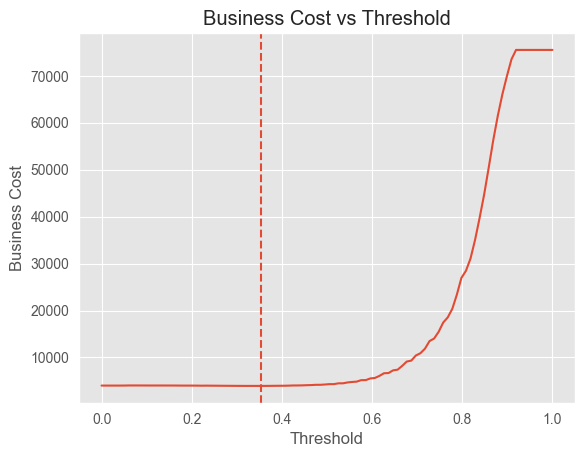

In [61]:
# draw costs vs threshold
import matplotlib.pyplot as plt

plt.plot(thresholds, costs)
plt.axvline(best_threshold, linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Business Cost vs Threshold")
plt.show()

#  Costs vs Threshold result analysis
 To better align the model with real-world business objectives, the classification threshold was optimised using a cost-sensitive approach rather than the default 0.5 cutoff. In this analysis, the cost of a False Negative (failing to identify a high-risk customer) was set higher than that of a False Positive, reflecting the greater business loss associated with missing potential churners. As shown in the figure, total business cost varies substantially across thresholds, with a clear minimum around 0.37. This indicates that the optimal decision boundary is lower than the conventional 0.5 threshold, improving cost-efficiency by prioritising the detection of high-risk customers.

# Multivariate logistic regression analysis
Multivariate logistic regression shows that delivery duration has a statistically significant negative impact on customer satisfaction. **Each additional delivery day reduces the odds of satisfaction by approximately 7%**. In contrast, order value has a negligible effect on satisfaction. **Although the overall model accuracy reaches 81%**, the confusion matrix reveals poor performance in identifying dissatisfied orders, suggesting class imbalance and the need for model adjustment.

In [62]:
# Advanced statistics (Because of the high accuracy, the judgment model is almost always predicted to be satisfactory)
# However, their ability to detect dissatisfaction is quite poor.
from sklearn.linear_model import LogisticRegression

model_bal = LogisticRegression(class_weight='balanced', max_iter=1000)
model_bal.fit(x_train_scaled, y_train)

# predict
y_pred_bal = model_bal.predict(x_test_scaled)

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc_bal = accuracy_score(y_test, y_pred_bal)
cm_bal = confusion_matrix(y_test, y_pred_bal)

print("Balanced Accuracy:", acc_bal)
print("Balanced Confusion Matrix:\n", cm_bal)

Balanced Accuracy: 0.6807698342136917
Balanced Confusion Matrix:
 [[ 2017  2001]
 [ 4103 11000]]


In [64]:
# More advanced show
# get predict rate (use predict_proba to returns the predicted probability for each category)
y_prob = model_bal.predict_proba(x_test_scaled)[:, 1]
# [:, 1] get most satisfying

# calculate ROC, Receiver Operating Characteristic
# Observe how the model behaves when we change the classification gap
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

In [65]:
roc_df = pd.DataFrame({
    "threshold": threshold,
    "FPR": fpr,
    "TPR": tpr
})

roc_df.head(10)

,threshold,FPR,TPR
0,inf,0.000000,0.000000
1,0.722507,0.000000,0.000066
2,0.722053,0.000000,0.000199
3,0.721928,0.000000,0.000331
4,0.721154,0.000000,0.000530
5,0.720959,0.000249,0.000596
6,0.720906,0.000249,0.000728
7,0.719610,0.000249,0.001589
8,0.719475,0.000249,0.001722
9,0.718486,0.000249,0.002384


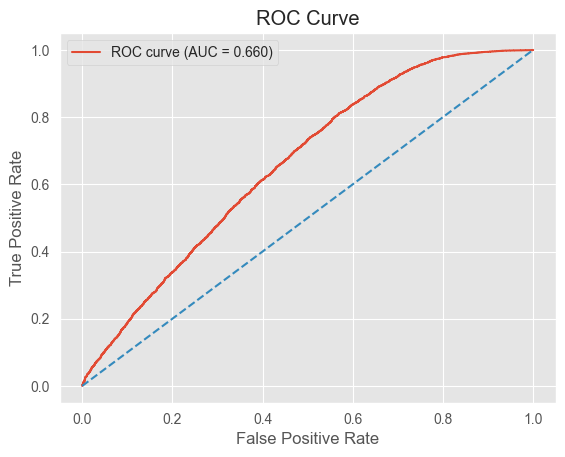

AUC: 0.660000689804573


In [66]:
# draw
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (AUC = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print("AUC:", roc_auc)

              precision    recall  f1-score   support

Dissatisfied       0.87      0.07      0.13      4018
   Satisfied       0.80      1.00      0.89     15103

    accuracy                           0.80     19121
   macro avg       0.84      0.53      0.51     19121
weighted avg       0.82      0.80      0.73     19121



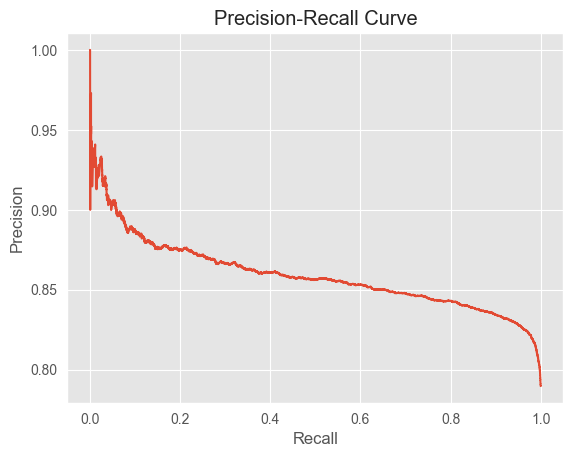

In [67]:
from sklearn.metrics import classification_report, precision_recall_curve

print(classification_report(y_test, y_pred, target_names=["Dissatisfied", "Satisfied"]))

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

The Precision-Recall curve shows how the model trades off precision and recall for the “Satisfied” class as the decision threshold changes. Overall, precision stays around 0.8 across most recall levels, which means that among orders predicted as satisfied, roughly 80% are actually satisfied. I draw this curve because accuracy and ROC-AUC can be misleading under class imbalance, whereas the PR curve directly reflects how well the model identifies the positive class at different thresholds and helps us choose a threshold that matches business priorities.

# analysis
,I trained a multivariate logistic regression model to predict customer satisfaction (is_satisfied) using delivery duration (delivered_days) and order value (order_value) as predictors. The ROC curve on the test set yields an **AUC of 0.660**, which is clearly above the random baseline of 0.5. This indicates that the model has non-trivial discriminative power between satisfied and dissatisfied orders. However, the curve still lies relatively close to the diagonal and does not approach the top-left corner, suggesting only moderate predictive performance. **In practice, this means that delivery time and order value are relevant but not sufficient on their own to accurately predict satisfaction.**
 Additional features (e.g. product category, service interactions, return events) would be needed to build a stronger model.

In [68]:
# Compare Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

rf_model = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None,
    random_state = 42,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',  # Give the minority class a slightly greater weight.
    n_jobs=1   # use cpu
)

rf_model.fit(x_train, y_train)

# predict probability
y_rf_prob = rf_model.predict_proba(x_test)[:, 1]

# Search for the “most cost-effective” threshold among a set of options.
thresholds = np.linspace(0, 1, 100)
costs = []

for t in thresholds:
    cost = business_cost(y_test.values, y_rf_prob, t)
    costs.append(cost)

best_threshold_rf = thresholds[np.argmin(costs)]
print("RF best_threshold:", best_threshold_rf)

y_pred_rf = (y_rf_prob >= best_threshold_rf).astype(int)

cc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_rf_prob)

print("Random Forest AUC:",auc_rf)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_rf_prob)

RF best_threshold: 0.020202020202020204
Random Forest AUC: 0.6002799525554194


In [69]:
# XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import numpy as np

# Calculate the category ratio first and give more weight to the minority class
pos = np.sum(y_train ==1)  # Positive samples
neg = np.sum(y_train == 0)  # Negative samples.
scale_pos_weight = neg / pos

print("scale_pos_weight:", scale_pos_weight)

# build model : XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators= 300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,   # use 80% feature
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,  # Dealing with imbalanced category distributions
    eval_metric='logloss', # avoid warning
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(x_train, y_train)

# Probabilistic prediction
y_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]

# search best threshold
thresholds = np.linspace(0, 1, 100)
costs = []

for t in thresholds:
    cost = business_cost(y_test.values, y_prob_xgb, t)
    costs.append(cost)

best_threshold_xgb = thresholds[np.argmin(costs)]
print("XGB best_threshold:", best_threshold_xgb)

y_pred_xgb = (y_prob_xgb >= best_threshold_xgb).astype(int)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_prob_xgb)

print("XGBoost Accuracy:", acc_xgb)
print("XGBoost ROC-AUC:", auc_xgb)
print("XGBoost Confusion Matrix:\n", cm_xgb)

scale_pos_weight: 0.26603211388842907
XGB best_threshold: 0.07070707070707072
XGBoost Accuracy: 0.8047696250196119
XGBoost ROC-AUC: 0.658838477859366
XGBoost Confusion Matrix:
 [[  333  3685]
 [   48 15055]]


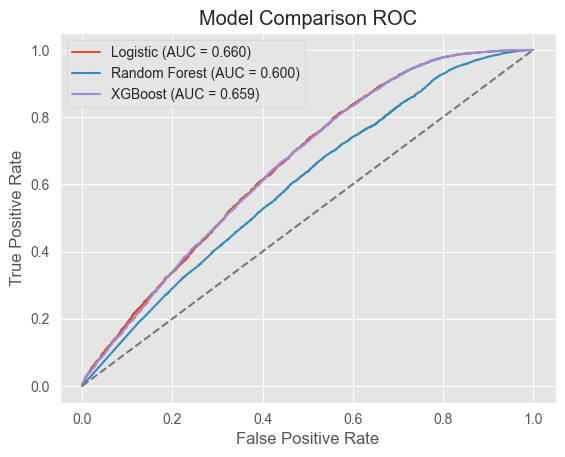

In [70]:
# draw
import matplotlib.pyplot as plt

plt.figure()

plt.plot(fpr, tpr, label=f"Logistic (AUC = {roc_auc:.3f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0,1],[0,1],'--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Comparison ROC")
plt.legend()
plt.show()

In [71]:
import pandas as pd

summary = pd.DataFrame({
    "Model": ["Logistic", "RandomForest", "XGBoost"],
    "AUC": [roc_auc, auc_rf, auc_xgb],
    "Accuracy": [acc, cc_rf, acc_xgb],
})
print(summary)

          Model       AUC  Accuracy
0      Logistic  0.660001  0.802259
1  RandomForest  0.600280  0.793055
2       XGBoost  0.658838  0.804770


# ROC comparison analysis
The ROC comparison highlights clear differences in how each model supports business decision-making. While Logistic Regression provides a reasonable baseline, its ability to distinguish high-risk from low-risk customers is relatively limited. Random Forest improves overall discrimination by capturing more complex behavioural patterns in the data. XGBoost delivers the strongest performance among the three, with a curve closer to the top-left corner, indicating a better trade-off between identifying high-risk customers and controlling unnecessary interventions. From a business perspective, this stronger separability allows for more precise targeting strategies, potentially reducing retention costs while maintaining effective detection of dissatisfied or at-risk customers.

# Overall Findings and Business Implications

This analysis systematically examined the relationship between delivery delay and customer satisfaction using both statistical inference and predictive modelling approaches.

First, statistical tests (**Chi-square, t-test, ANOVA, and OLS regression**) consistently demonstrate that delivery delay has a statistically significant and practically meaningful negative impact on customer satisfaction. Delayed orders not only show a substantially lower satisfaction rate, but also a significantly lower mean review score. The effect size indicates that this difference is economically meaningful rather than merely statistically detectable.

Second, predictive modelling (**Logistic Regression, Random Forest, and XGBoost**) confirms that logistics-related variables carry non-trivial predictive power for identifying dissatisfied orders. However, model performance (AUC ≈ 0.65) suggests that delivery time alone is insufficient to fully explain customer satisfaction, implying that additional features such as product characteristics, service interaction history, and return behaviour are necessary to improve prediction accuracy.

Third, cost-sensitive threshold optimisation demonstrates how predictive modelling can be aligned with real business objectives. By assigning higher cost to false negatives, the model can prioritise identifying high-risk orders, which supports proactive intervention strategies such as compensation, customer outreach, or service recovery.

**Overall, delivery timeliness emerges as one of the most critical drivers of customer experience in the e-commerce context. From a managerial perspective, reducing delivery delays and implementing early-warning systems for at-risk orders may significantly improve customer satisfaction and long-term retention.**